In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import re
from wandb import Api
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d
import matplotlib

api = Api()

In [2]:
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
import matplotlib.pyplot as plt
import seaborn as sns

num_colors = 6
colour = []
for j in range(num_colors):
    blue = np.array([0, 200, 255, 255])/255
    pink = np.array([238, 20, 238,255])/255
    colour += [pink+((j/5)*(blue-pink))]

In [3]:
sns.set_theme(
    context="paper",
    font_scale=1.0,
    style="white",
    font="sans-serif",
    palette=colour[:3] + [c / 1.3 for c in colour[4:]],
)

sns.set_style(rc={"xtick.bottom": True, "ytick.left": True})

matplotlib.rc("xtick", labelsize=10)
matplotlib.rc("ytick", labelsize=10)

In [4]:
import decimal

# create a new context for this task
ctx = decimal.Context()

# 20 digits should be enough for everyone :D
ctx.prec = 20


def float_to_str(f):
    """
    Convert the given float to a string,
    without resorting to scientific notation
    """
    d1 = ctx.create_decimal(repr(f))
    return format(d1, "f")


def float_to_e_str(f):
    """
    Convert the given float to a string,
    resorting to scientific notation
    """
    d1 = ctx.create_decimal(repr(f))
    return format(d1, "e")

# Utility

In [5]:
def runs_to_df(runs, include_history=True):
    """Convers a list of runs to a dataframe"""
    return pd.DataFrame.from_records(
        [
            dict(
                **dict(run.summary),
                **dict(run.config),
                **dict(
                    run=run,
                    state=run.state,
                    name=run.name,
                    tags=run.tags,
                    history=run.history() if include_history else None,
                    sweep_name=run.sweep_name,
                )
            )
            for run in runs
        ]
    )

In [6]:
def dataset_name_to_dataset_features(dataset_name):
    split_name = re.split(r"F_|_MM_|_AT_", dataset_name)
    filtering, mix_match, adv_training = split_name[1], split_name[2], split_name[3]
    return dict(filtering=filtering, mix_match=mix_match, adv_training=adv_training)

In [7]:
dataset_name_to_training_type = {
    "F_features_Foreshadowing_MM_features_Foreshadowing_Twist_AT_none": "Specialisation + Mix Match",
    "F_features_x_Foreshadowing_MM_none_AT_features_Foreshadowing_0.5": "Filtering + 50% Adversarial Training",
    "F_features_x_Foreshadowing_MM_none_AT_features_Foreshadowing_1.0": "Filtering + 100% Adversarial Training",
    "F_features_x_Foreshadowing_MM_none_AT_none": "Filtering",
    "F_features_x_Foreshadowing_features_Twist_MM_none_AT_features_Foreshadowing_0.5": "Filtering + Specialisation + 50% Adversarial Training",
    "F_features_x_Foreshadowing_features_Twist_MM_none_AT_features_Foreshadowing_1.0": "Filtering + Specialisation + 100% Adversarial Training",
    "F_features_x_Foreshadowing_features_Twist_MM_none_AT_none": "Filtering + Specialisation",
    "F_none_MM_features_Foreshadowing_Twist_AT_none": "Mix Match",
    "F_features_Twist_MM_features_Twist_Foreshadowing_AT_none": "Specialisation + Mix Match",
    "F_features_x_Twist_MM_none_AT_features_Twist_0.5": "Filtering + 50% Adversarial Training",
    "F_features_x_Twist_MM_none_AT_features_Twist_1.0": "Filtering + 100% Adversarial Training",
    "F_features_x_Twist_MM_none_AT_none": "Filtering",
    "F_features_x_Twist_features_Foreshadowing_MM_none_AT_features_Twist_0.5": "Filtering + Specialisation + 50% Adversarial Training",
    "F_features_x_Twist_features_Foreshadowing_MM_none_AT_features_Twist_1.0": "Filtering + Specialisation + 100% Adversarial Training",
    "F_features_x_Twist_features_Foreshadowing_MM_none_AT_none": "Filtering + Specialisation",
    "F_none_MM_features_Twist_Foreshadowing_AT_none": "Mix Match",
    "F_features_Foreshadowing_MM_none_AT_none": "Recovery",
    "F_features_Twist_MM_none_AT_none": "Recovery",
    "filter-adv-Twist": "Filtering + Adversarial Training",
    "filter-Twist": "Filtering",
    "filter-Twist-specialise-Foreshadowing": "Filtering + Specialisation",
    "filter-adv-Twist-specialise-Foreshadowing": "Filtering + Specialisation + Adversarial Training",
    "filter-mix-Twist-Foreshadowing": "Filtering + Mix & Match",
    "filter-mix-specialise-Twist-Foreshadowing": "Filtering + Specialisation + Mix & Match",
    "specialise-Twist": "Recovery",
    "pretrain-all": "Probing",
}
important_training_types = {
    "Filtering + Adversarial Training",
    "Filtering + Mix & Match",
    "Filtering",
    "Recovery",
    "Not in Pretraining",
    "Present in Pretraining",
    "Probing",
}
fs_loss_name_to_eval_type = {
    "loss/F_features_Foreshadowing_MM_none_AT_none": "Task Loss",
    "loss/F_features_x_Foreshadowing_MM_none_AT_features_Foreshadowing_1.0": "Adversarial Loss",
    "loss/F_features_x_Foreshadowing_MM_none_AT_none": "No-Task Loss",
    "loss/F_features_Foreshadowing_MM_features_Foreshadowing_Twist_AT_none": "Spurious Correlation Loss",
}
twist_loss_name_to_eval_type = {
    "loss/F_features_Twist_MM_none_AT_none": "Task Loss",
    "loss/F_features_x_Twist_MM_none_AT_features_Twist_1.0": "Adversarial Loss",
    "loss/F_features_x_Twist_MM_none_AT_none": "No-Task Loss",
    "loss/F_features_Twist_MM_features_Twist_Foreshadowing_AT_none": "Spurious Correlation Loss",
    "loss/specialise-Twist": "Task Loss",
    "loss/filter-Twist": "Complement Task Loss",
}

In [8]:
deletion_model_names_to_info = {
    "base91M-delete-2023_11_15_01_33_44_884": {
        "training_type": "Filtering + Specialisation + Mix & Match",
        "learning_rate": 1e-05,
    },
    "base91M-delete-2023_11_15_00_34_11_922": {
        "training_type": "Filtering + Specialisation + Mix & Match",
        "learning_rate": 0.001,
    },
    "base91M-delete-2023_11_15_01_03_58_118": {
        "training_type": "Filtering + Specialisation + Mix & Match",
        "learning_rate": 0.0001,
    },
    "base91M-delete-2023_11_14_22_35_03_674": {
        "training_type": "Filtering + Specialisation + Adversarial Training",
        "learning_rate": 1e-05,
    },
    "base91M-delete-2023_11_14_22_05_12_020": {
        "training_type": "Filtering + Specialisation + Adversarial Training",
        "learning_rate": 0.0001,
    },
    "base91M-delete-2023_11_14_21_35_29_461": {
        "training_type": "Filtering + Specialisation + Adversarial Training",
        "learning_rate": 0.001,
    },
    "base91M-delete-2023_11_14_19_36_21_032": {
        "training_type": "Filtering + Specialisation",
        "learning_rate": 1e-05,
    },
    "base91M-delete-2023_11_14_18_36_33_675": {
        "training_type": "Filtering + Specialisation",
        "learning_rate": 0.001,
    },
    "base91M-delete-2023_11_14_19_06_32_176": {
        "training_type": "Filtering + Specialisation",
        "learning_rate": 0.0001,
    },
    "base91M-delete-2023_11_15_00_04_35_349": {
        "training_type": "Filtering + Mix & Match",
        "learning_rate": 1e-05,
    },
    "base91M-delete-2023_11_14_23_34_52_041": {
        "training_type": "Filtering + Mix & Match",
        "learning_rate": 0.0001,
    },
    "base91M-delete-2023_11_14_23_05_07_460": {
        "training_type": "Filtering + Mix & Match",
        "learning_rate": 0.001,
    },
    "base91M-delete-2023_11_14_21_05_30_945": {
        "training_type": "Filtering + Adversarial Training",
        "learning_rate": 1e-05,
    },
    "base91M-delete-2023_11_14_20_06_05_134": {
        "training_type": "Filtering + Adversarial Training",
        "learning_rate": 0.001,
    },
    "base91M-delete-2023_11_14_20_35_51_288": {
        "training_type": "Filtering + Adversarial Training",
        "learning_rate": 0.0001,
    },
    "base91M-delete-2023_11_14_18_06_34_850": {
        "training_type": "Filtering",
        "learning_rate": 1e-05,
    },
    "base91M-delete-2023_11_14_17_36_32_483": {
        "training_type": "Filtering",
        "learning_rate": 0.0001,
    },
    "base91M-delete-2023_11_14_17_06_22_921": {
        "training_type": "Filtering",
        "learning_rate": 0.001,
    },
    "base91M-train-2023_11_15_16_56_22": {
        "training_type": "Not in Pretraining",
        "learning_rate": 0.0,
    },
    "base91M-train-2023_11_14_14_13_20": {
        "training_type": "Present in Pretraining",
        "learning_rate": 0.0,
    },
}

In [9]:
def get_model_dir(model_path):
    """Get base91M-.... out of /../../..../base91M-.../../ with regex

    Make sure not to get any following slashes
    """
    return re.findall(r"base91M-.*?(?=/)", model_path)[0]

In [10]:
get_model_dir(
    "/home/rowan/code/transformers/examples/language-modeling/runs/base91M-delete-2023_11_15_01_33_44_884/out/hello"
)

'base91M-delete-2023_11_15_01_33_44_884'

In [11]:
def filter_df(
    df, tags=None, important_only=False, include_deletion_info=False, filter_lrs=True
):
    df = df[df["state"] != "failed"]
    df = df[df["state"] != "crashed"]
    # remove runs with 0.01 and 0.001 learning rates
    if filter_lrs:
        df = df[~df["learning_rate"].isin([0.01, 0.001])]
    if tags:
        df = df[df["tags"].apply(lambda x: set(x).issuperset(set(tags)))]
    # df = pd.concat(
    #     [
    #         df,
    #         df["dataset_name"].apply(dataset_name_to_dataset_features).apply(pd.Series),
    #     ],
    #     axis=1,
    # )
    # df.sort_values(by=["dataset_name", "learning_rate"], inplace=True)
    df["training_type"] = df["dataset_name"].apply(
        lambda x: dataset_name_to_training_type[x]
    )
    if include_deletion_info:
        df["deletion_lr"] = df["model_dir"].apply(
            lambda x: deletion_model_names_to_info[get_model_dir(x)]["learning_rate"]
        )
        df["deletion_type"] = df["model_dir"].apply(
            lambda x: deletion_model_names_to_info[get_model_dir(x)]["training_type"]
        )
        df = df[~df["deletion_lr"].isin([0.01, 0.001])]

    if important_only:
        df = df[df["training_type"].isin(important_training_types)]
        df["training_type"] = df["training_type"].apply(
            lambda x: x.replace("100% ", "")
        )
        if include_deletion_info:
            df = df[df["deletion_type"].isin(important_training_types)]
            df["deletion_type"] = df["deletion_type"].apply(
                lambda x: x.replace("100% ", "")
            )
    return df

In [12]:
def get_model_names(df, prefix="/cache/tinystories/", postfix="/out"):
    print(
        f"  - {prefix}"
        + f"{postfix}\n  - {prefix}".join(
            df[df["learning_rate"].isin([0.001, 0.0001, 0.00001])]["name"].tolist()
        )
        + postfix
    )

In [13]:
def make_del_plot(df, y, hue="training_type", **kwargs):
    sns.set_style("whitegrid")
    g = sns.catplot(
        data=df,
        x="state",
        hue=hue,
        y=y,
        col="learning_rate",
        kind="bar",
        legend=True,
        legend_out=True,
        orient="v",
        **kwargs,
        height=2
    )
    # Remove x-axis labels and ticks
    g.set(xlabel=None)
    g.set_xticklabels([])
    # despine
    sns.despine(left=True)
    # remove tick dashes from x-axis
    g.set(xticks=[])
    # have horizontal grid lines
    g.tight_layout()
    g.set(yticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
    return g

In [14]:
def make_rc_plot(df, y, hue="training_type", **kwargs):
    sns.set_style("whitegrid")
    g = sns.catplot(
        data=df,
        x="state",
        hue=hue,
        y=y,
        kind="bar",
        legend=True,
        legend_out=True,
        orient="v",
        **kwargs,
        height=3
    )
    # Remove x-axis labels and ticks
    g.set(xlabel=None)
    g.set_xticklabels([])
    # despine
    sns.despine(left=True)
    # remove tick dashes from x-axis
    g.set(xticks=[])
    g.tight_layout()
    g.set(yticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
    return g

In [15]:
def make_history_plots(
    df,
    metric,
    split_key,
    save_fig=None,
    smoothing=False,
    logx=False,
    logy=False,
    baseline=None,
    x="iter",
    cut_iter_num_gen=False,
    offset_x=0,
    **kwargs,
):
    histories = []
    for _, row in df.iterrows():
        # Add information in row to history df
        # row["history"] is a dataframe, add new columns to it from row
        hist_df = row["history"].copy()
        for column in list(row.index):
            if column != "history" and column not in hist_df.columns:
                hist_df[column] = [row[column]] * len(hist_df)
        # Add smoothed version of metric
        hist_df[f"{metric}_smooth"] = gaussian_filter1d(hist_df[metric], sigma=2)
        # add baselined version of metric: metric - baseline
        if baseline:
            hist_df[f"{metric}_baseline"] = hist_df[metric] - baseline
            # Add smoothed baseline metric
            hist_df[f"{metric}_baseline_smooth"] = gaussian_filter1d(
                hist_df[f"{metric}_baseline"], sigma=2
            )
        if logy:
            hist_df[f"log_{metric}"] = np.log(hist_df[metric])
            hist_df[f"log_{metric}_smooth"] = gaussian_filter1d(
                hist_df[f"log_{metric}"], sigma=2
            )
        if cut_iter_num_gen:
            num_iter_num_gens = len(
                hist_df[~hist_df["iter_num_gen"].isna()]["iter_num_gen"].unique()
            )
            hist_df.sort_values(by="iter", inplace=True)
            hist_df = hist_df[
                (~hist_df["iter_num_gen"].isnull()) & (~hist_df[metric].isnull())
            ][-num_iter_num_gens:]
            hist_df[f"{metric}_smooth"] = gaussian_filter1d(hist_df[metric], sigma=1.5)
        histories.append(hist_df)
    # Create df from all history dfs
    histdf = pd.concat(histories)
    histdf.reset_index(inplace=True)
    metric = (
        ("log_" if logy else "")
        + metric
        + ("_baseline" if baseline else "")
        + ("_smooth" if smoothing else "")
    )
    if offset_x:
        histdf[x] = histdf[x] + offset_x
    default_kwargs = dict(
        data=histdf,
        y=metric,
        x=x,
        hue=split_key,
        kind="line",
        height=2.5,
        aspect=2,
    )
    default_kwargs.update(kwargs)
    g = sns.relplot(**default_kwargs)
    if "loss" in metric.lower():
        g.set(ylabel="Loss")
        if baseline:
            g.set(ylabel="Loss - Baseline Loss")
        if logy:
            g.set(ylabel="Log Loss")
    elif "gen_feature" in metric.lower():
        g.set(ylabel="Generation Score")

    # set x-axis name to Training Iteration
    g.set(xlabel=None)
    if logx:
        g.set(xscale="log")
        g.set(xlim=(1, 4100))
    else:
        # Set xtick names to 0-5
        g.set(xticks=range(-1000, 5000, 1000))
        g.set_xticklabels(range(-1, 5))
        # set x-lim to 0,5000
        g.set(xlim=(-100, 4100))

    # Set legend title to split_key
    g._legend.set_title(split_key.replace("_", " ").title())
    # set titles to learning rate
    g.set_titles("LR = {col_name}")
    if "deletion" in split_key:
        g.set_titles("Deletion LR = {col_name}")

    # set x-axis label between two subplots
    g.fig.text(
        0.5, -0.0, "Training Iteration (x1000)", ha="center", va="center", fontsize=10
    )

    # put legend above plot
    sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, 0.9), ncol=3)
    plt.tight_layout()
    if save_fig:
        g.savefig(f"{save_fig}.pdf", bbox_inches="tight", dpi=300)
    return g, histdf

In [193]:
print("hi")

hi


# AWS Experiments

## Deletion

In [194]:
tw_df_aws = runs_to_df(
    list(api.runs("ucl-dark/tinystories-uft", filters={"tags": "twist-delete-aws"}))
)

In [195]:
tw_df_aws = filter_df(tw_df_aws, tags=["twist-delete-aws"], important_only=True)
tw_df_aws = tw_df_aws[~tw_df_aws["lr_scheduling"].isnull()]
tw_df_aws.rename(columns=twist_loss_name_to_eval_type, inplace=True)
_ = tw_df_aws["history"].apply(
    lambda x: x.rename(columns=twist_loss_name_to_eval_type, inplace=True)
)
tw_df_aws.sort_values(by="training_type", inplace=True, ascending=True)
tw_df_aws["learning_rate"] = tw_df_aws["learning_rate"].map(float_to_e_str)

### Testing Loss

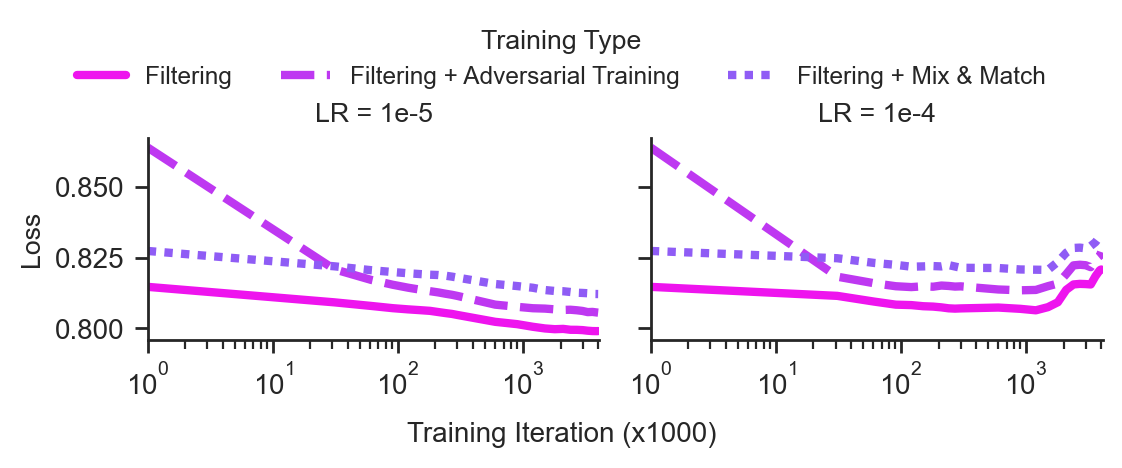

In [196]:
g, _ = make_history_plots(
    tw_df_aws,
    metric="loss/test",
    split_key="training_type",
    col="learning_rate",
    style="training_type",
    height=1.8,
    aspect=1,
    linewidth=3,
    logx=True,
    offset_x=1,
    save_fig="twist_deletion_id_test_loss",
)

### Twist Generations Loss

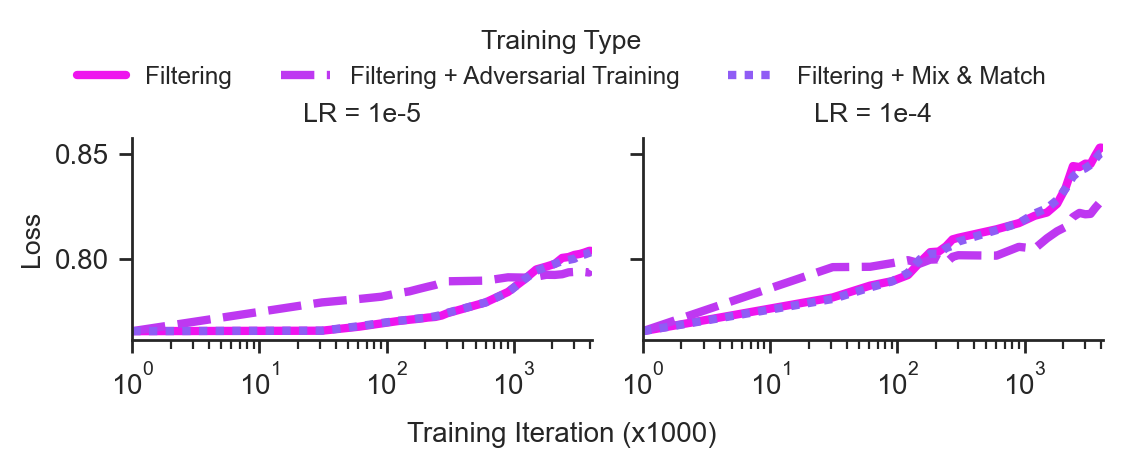

In [197]:
g, _ = make_history_plots(
    tw_df_aws,
    metric="Task Loss",
    split_key="training_type",
    col="learning_rate",
    style="training_type",
    height=1.8,
    aspect=1,
    save_fig="twist_deletion_twist_loss",
    logx=True,
    offset_x=1,
    linewidth=3,
)

### Twist Prompt Generations Score

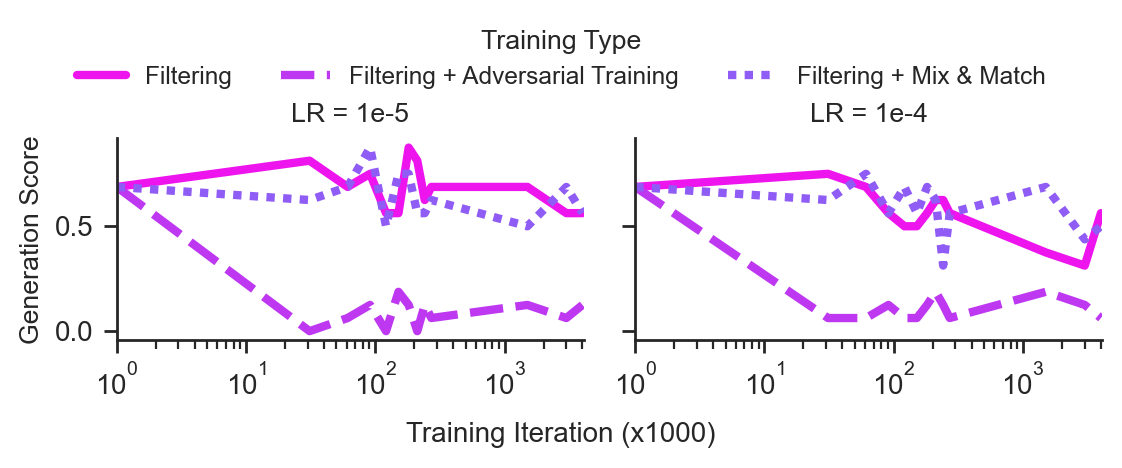

In [198]:
g, histdf = make_history_plots(
    tw_df_aws,
    metric="gen_feature_adv",
    x="iter_num_gen",
    split_key="training_type",
    col="learning_rate",
    style="training_type",
    height=1.8,
    aspect=1,
    save_fig="twist_deletion_gen_score",
    linewidth=3,
    offset_x=1,
    logx=True,
    cut_iter_num_gen=True,
    # smoothing=True,
)

## Recovery

In [199]:
tw_df_aws_rec = runs_to_df(
    list(api.runs("ucl-dark/tinystories-uft", filters={"tags": "twist-recovery-aws"}))
)

In [200]:
tw_df_aws_rec = filter_df(
    tw_df_aws_rec,
    tags=["twist-recovery-aws"],
    important_only=True,
    include_deletion_info=True,
)
tw_df_aws_rec.rename(columns=twist_loss_name_to_eval_type, inplace=True)
_ = tw_df_aws_rec["history"].apply(
    lambda x: x.rename(columns=twist_loss_name_to_eval_type, inplace=True)
)
tw_df_aws_rec.sort_values(by="deletion_type", inplace=True, ascending=True)

In [201]:
# Remove row for "Not in Pretraining", add back in with all learning rates
pre_row = (
    tw_df_aws_rec[tw_df_aws_rec["deletion_type"] == "Not in Pretraining"].iloc[0].copy()
)
pre_row_c1 = pre_row.copy()
pre_row_c2 = pre_row.copy()
pre_row_c1["deletion_lr"] = 1e-5
pre_row_c2["deletion_lr"] = 1e-4

# Delete pre_row from df
tw_rc_df_agg = tw_df_aws_rec[tw_df_aws_rec["deletion_type"] != "Not in Pretraining"]
# make new df out of pre_row
pre_df = pd.concat([pre_row_c1, pre_row_c2], axis=1).T
# append pre_df to df
tw_rc_df_agg = pd.concat([tw_rc_df_agg, pre_df], axis=0)
tw_rc_df_agg["deletion_lr"] = tw_rc_df_agg["deletion_lr"].apply(float_to_e_str)
tw_rc_df_agg.sort_values(by="deletion_type", inplace=True, ascending=True)

### Testing (Twist) Loss

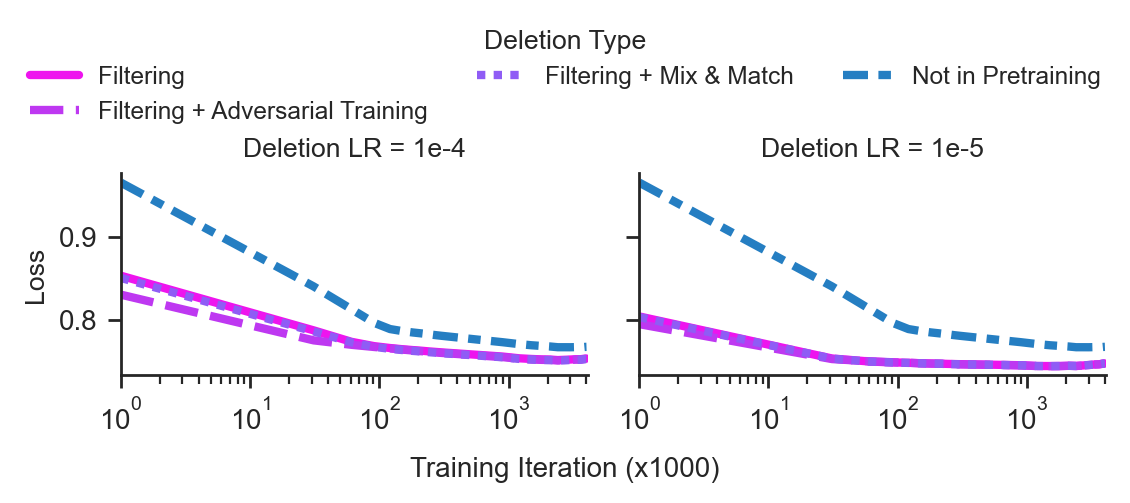

In [202]:
g, _ = make_history_plots(
    tw_rc_df_agg,
    metric="loss/test",
    split_key="deletion_type",
    col="deletion_lr",
    style="deletion_type",
    height=1.8,
    aspect=1,
    save_fig="twist_recovery_id_test_loss",
    linewidth=3,
    logx=True,
    offset_x=1,
)

### Twist Prompt Generation score

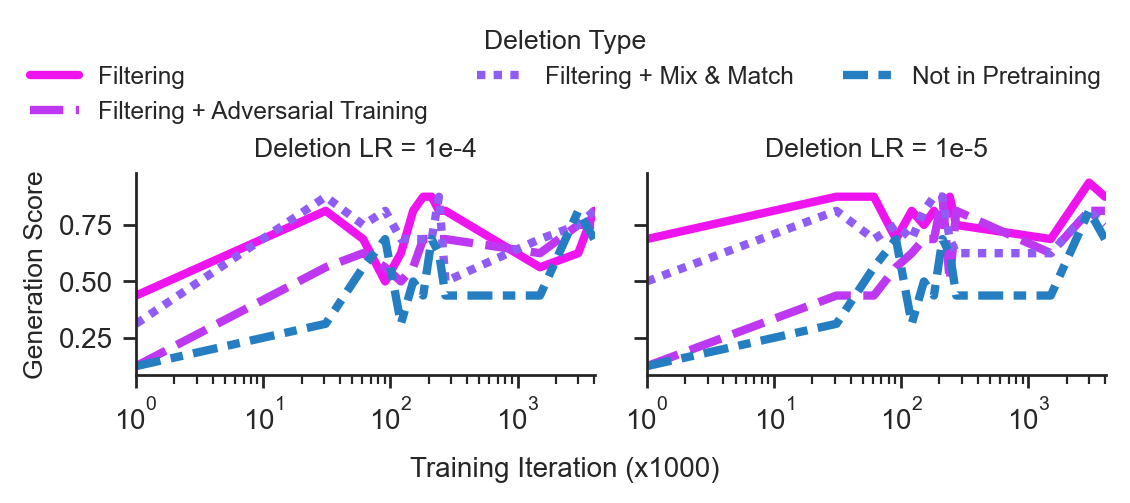

In [203]:
g, _ = make_history_plots(
    tw_rc_df_agg,
    metric="gen_feature_adv",
    x="iter_num_gen",
    split_key="deletion_type",
    col="deletion_lr",
    style="deletion_type",
    height=1.8,
    aspect=1,
    save_fig="twist_recovery_gen_score",
    linewidth=3,
    offset_x=1,
    logx=True,
    cut_iter_num_gen=True,
    # smoothing=True,
)

### Twist Prompt Generations Table

In [204]:
import math

In [205]:
del_type_to_short_name = {
    "Filtering": "F",
    "Filtering + Adversarial Training": "F+AT",
    "Filtering + Mix & Match": "F+MM",
    "Not in Pretraining": "Not in Pretraining",
}

In [206]:
table_df = tw_df_aws_rec[["deletion_lr", "deletion_type", "history"]]
table_df.sort_values(by=["deletion_lr", "deletion_type"], inplace=True, ascending=True)
rows = {}
chosen_iters = {0.0, 30.0, 270.0, 3000.0}
for i, row in table_df.iterrows():
    vals = []
    for j, hist_row in row["history"].iterrows():
        if hist_row["iter_num_gen"] in chosen_iters and not math.isnan(
            hist_row["gen_feature_adv"]
        ):
            vals.append(hist_row["gen_feature_adv"])
        # rows.append(
        #     {
        #         "deletion_lr": row["deletion_lr"],
        #         "deletion_type": row["deletion_type"],
        #         "gen_iter": hist_row["iter_num_gen"],
        #         "score": hist_row["gen_feature_adv"],
        #     }
        # )
    rows[
        del_type_to_short_name[row["deletion_type"]]
        + f"; LR {float_to_e_str(row['deletion_lr'])}"
    ] = vals

for k, row in rows.items():
    print(" & ".join([k] + [f"{v:.2f}" for v in row]) + r" \\")

Not in Pretraining; LR 0e-1 & 0.12 & 0.31 & 0.44 & 0.81 \\
F; LR 1e-5 & 0.69 & 0.88 & 0.75 & 0.94 \\
F+AT; LR 1e-5 & 0.12 & 0.44 & 0.81 & 0.81 \\
F+MM; LR 1e-5 & 0.50 & 0.81 & 0.62 & 0.81 \\
F; LR 1e-4 & 0.44 & 0.81 & 0.81 & 0.62 \\
F+AT; LR 1e-4 & 0.12 & 0.56 & 0.69 & 0.75 \\
F+MM; LR 1e-4 & 0.31 & 0.88 & 0.50 & 0.75 \\


/var/folders/k1/v581f0256q5_7vtxh75f36th0000gn/T/ipykernel_50346/3504013457.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_df.sort_values(by=["deletion_lr", "deletion_type"], inplace=True, ascending=True)


## Probing

In [207]:
tw_df_probe = runs_to_df(
    list(api.runs("ucl-dark/tinystories-uft", filters={"tags": "twist-probing-aws"})),
    include_history=False,
)

In [208]:
tw_df_probe = filter_df(
    tw_df_probe,
    tags=["twist-probing-aws"],
    important_only=True,
    include_deletion_info=True,
    filter_lrs=False,
)

In [209]:
# Remove row for "Not in Pretraining", add back in with all learning rates
for row_name in ("Not in Pretraining", "Present in Pretraining"):
    pre_row = tw_df_probe[tw_df_probe["deletion_type"] == row_name].iloc[0].copy()
    pre_rows = []
    for deletion_lr in (1e-5, 1e-4):
        pre_row_c = pre_row.copy()
        pre_row_c["deletion_lr"] = deletion_lr
        pre_rows.append(pre_row_c)

    # Delete pre_row from df
    tw_df_probe = tw_df_probe[tw_df_probe["deletion_type"] != row_name]
    # make new df out of pre_row
    pre_df = pd.concat(pre_rows, axis=1).T
    # append pre_df to df
    tw_df_probe = pd.concat([tw_df_probe, pre_df], axis=0)

tw_df_probe.sort_values(by="deletion_type", inplace=True, ascending=True)
tw_df_probe["deletion_lr"] = tw_df_probe["deletion_lr"].apply(float_to_e_str)

In [219]:
def make_probe_plot(df, feat, ncol=3):
    rows = []
    for _, row in df.iterrows():
        for i in range(11):
            new_row = row.copy()
            new_row["probe_index"] = i
            new_row["probe_accuracy"] = row[f"acc/test/feat_{feat}/probe_{i}"]
            rows.append(new_row)

    plot_df = pd.DataFrame(rows)

    g = sns.relplot(
        data=plot_df,
        x="probe_index",
        y="probe_accuracy",
        col="deletion_lr",
        hue="deletion_type",
        style="deletion_type",
        # markers=True,
        kind="line",
        height=1.8,
        aspect=1,
        linewidth=3,
    )
    # label
    g.set(xlabel=None, ylabel="Probe Accuracy")
    # xticks 0-10
    g.set(xticks=range(11))
    # set x-axis label between two subplots
    g.fig.text(0.5, -0.0, "Probe Layer Index", ha="center", va="center", fontsize=10)
    g._legend.set_title("Deletion Type")
    g.set_titles("Deletion LR: {col_name}")
    sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, 0.9), ncol=ncol)
    plt.tight_layout()
    return g

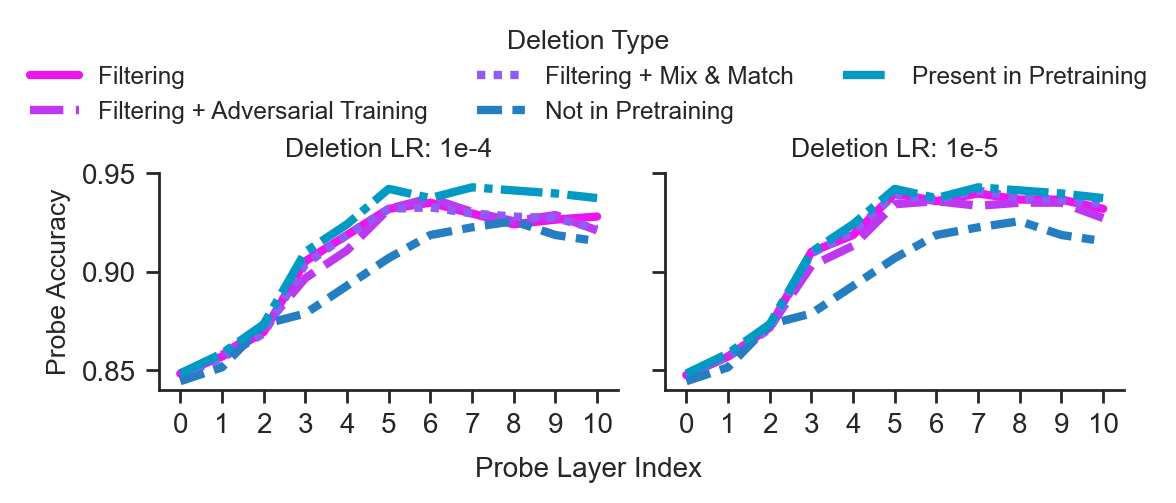

In [211]:
g = make_probe_plot(tw_df_probe, "0")
# y ticks .84 - .96
g.set(ylim=(0.84, 0.95))
g.savefig("twist_probe_twist.pdf", dpi=300, bbox_inches="tight")
g

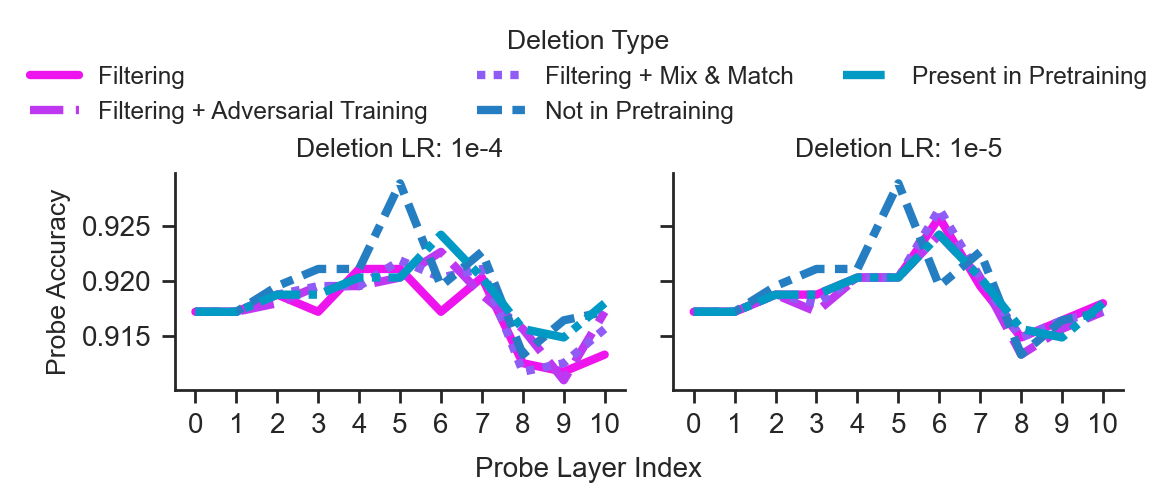

In [212]:
g = make_probe_plot(tw_df_probe, "1")
g.savefig("twist_probe_feat_1.pdf", dpi=300, bbox_inches="tight")
g

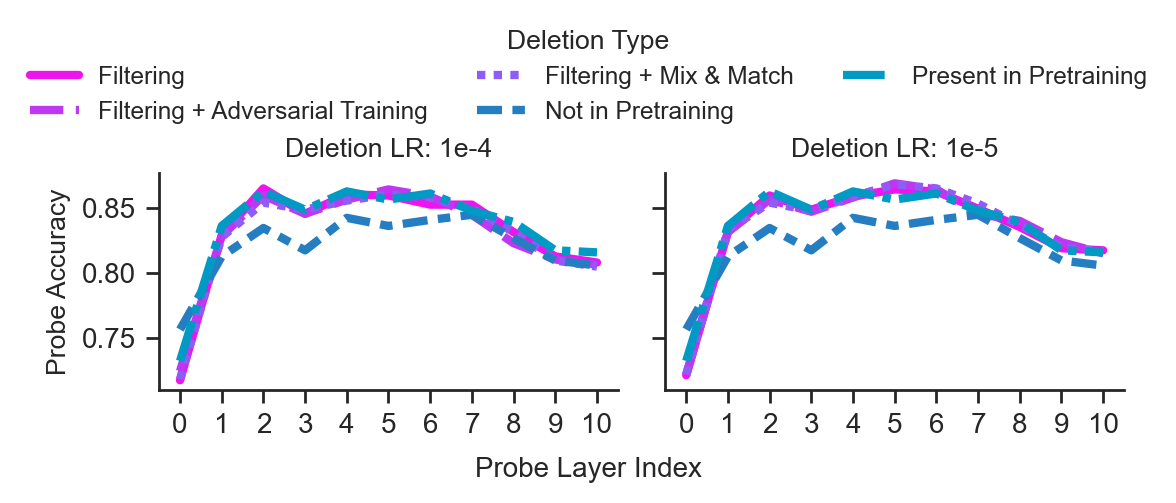

In [213]:
g = make_probe_plot(tw_df_probe, "2")
g.savefig("twist_probe_feat_2.pdf", dpi=300, bbox_inches="tight")
g

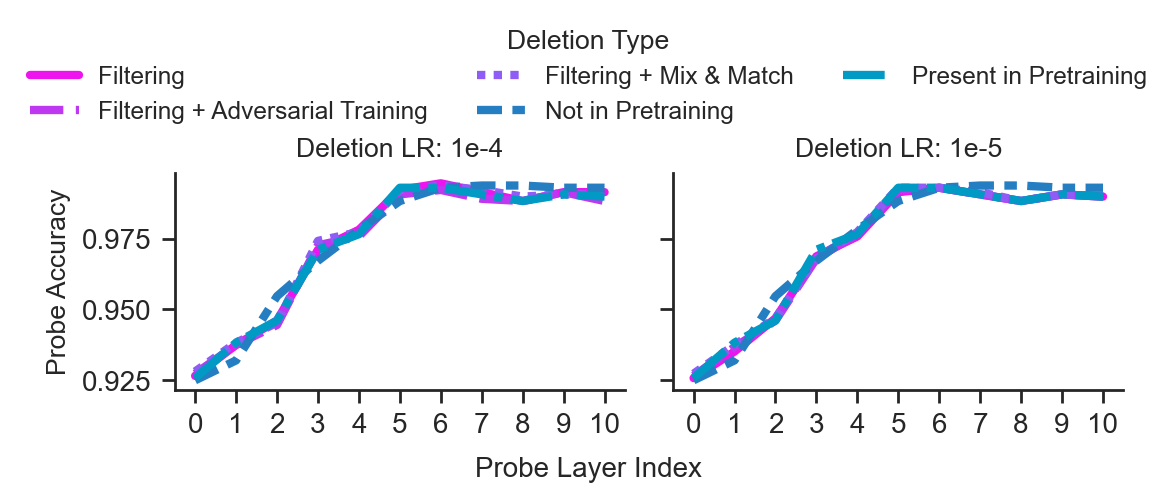

In [214]:
g = make_probe_plot(tw_df_probe, "3")
g.savefig("twist_probe_feat_3.pdf", dpi=300, bbox_inches="tight")
g

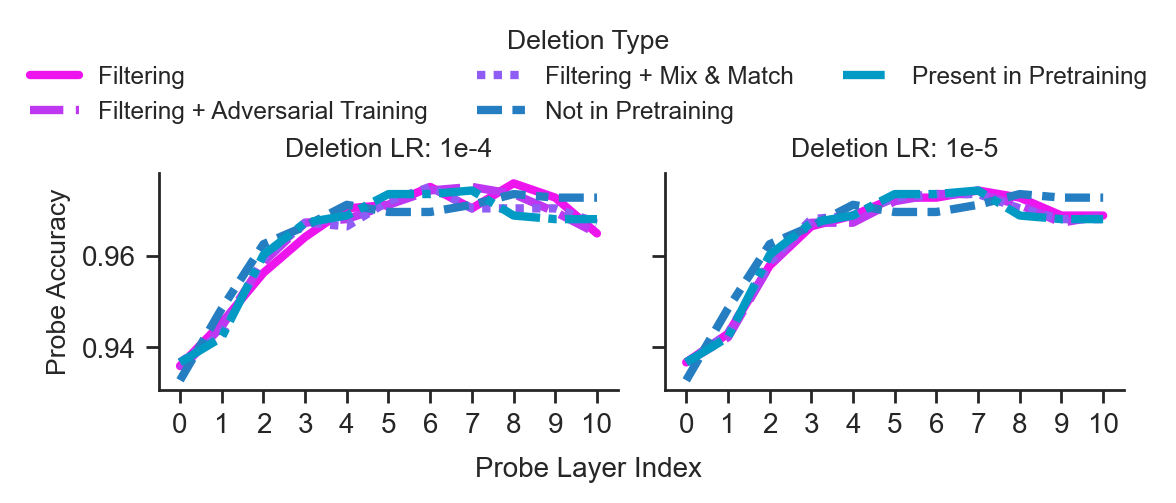

In [215]:
g = make_probe_plot(tw_df_probe, "4")
g.savefig("twist_probe_feat_4.pdf", dpi=300, bbox_inches="tight")
g

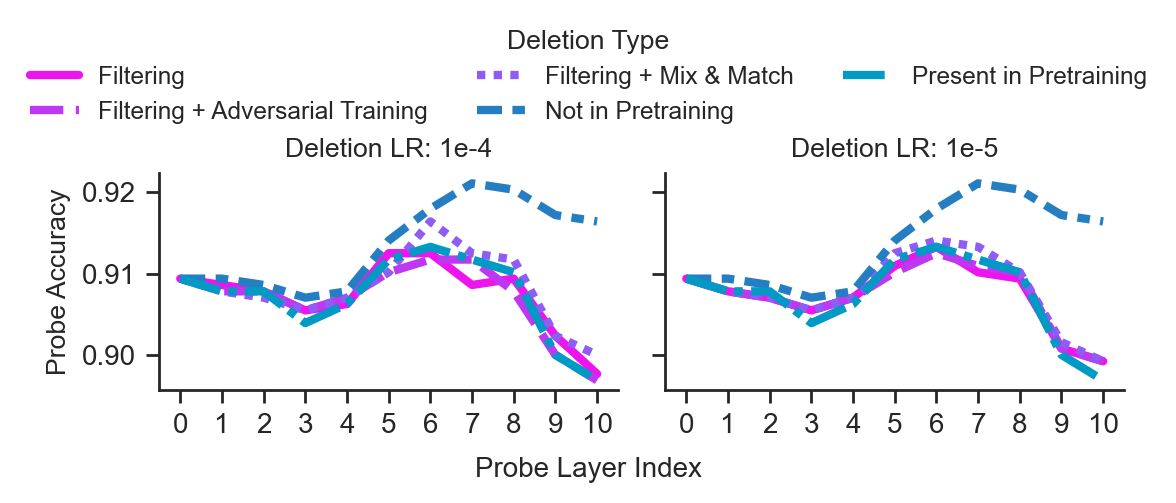

In [216]:
g = make_probe_plot(tw_df_probe, "5")
g.savefig("twist_probe_feat_5.pdf", dpi=300, bbox_inches="tight")
g

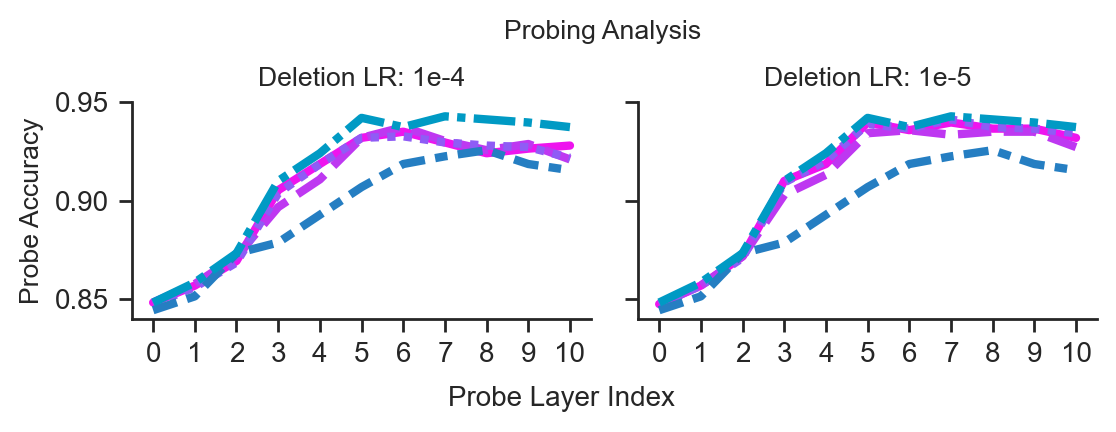

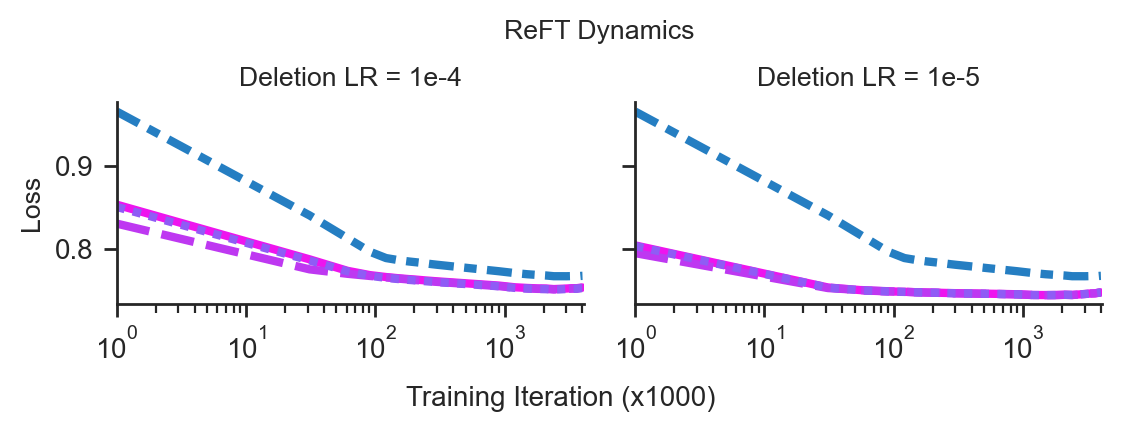

In [228]:
gl = make_probe_plot(tw_df_probe, "0")
gl.set(ylim=(0.84, 0.95))
# remove legend
gl._legend.remove()
# set title probe dynamics
gl.fig.text(0.45, 1, "Probing Analysis")
# save figure
gl.savefig("twist_probe_twist_legend.pdf", dpi=300, bbox_inches="tight")

gr, _ = make_history_plots(
    tw_rc_df_agg,
    metric="loss/test",
    split_key="deletion_type",
    col="deletion_lr",
    style="deletion_type",
    height=1.8,
    aspect=1,
    save_fig="twist_recovery_id_test_loss",
    linewidth=3,
    logx=True,
    offset_x=1,
)
# remove legend
gr._legend.remove()
# set title ReFT Dynamics
gr.fig.text(0.45, 1, "ReFT Dynamics")
# save figure
gr.savefig("twist_recovery_legend.pdf", dpi=300, bbox_inches="tight")

# make plot which is just legend